In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, ReLU, MaxPool2D, Add, Dense, Dropout, Flatten, GlobalAveragePooling2D
import tensorflow.compat.v1 as tf1

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import numpy as np

import PIL

import albumentations as albu

from tqdm.auto import tqdm

import random
random.seed(42)

from warnings import filterwarnings

%matplotlib inline

In [2]:
albu.__version__
pd.__version__

'1.0.4'

In [3]:
filterwarnings('ignore')

In [4]:
config = tf1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf1.Session(config=config)
tf1.keras.backend.set_session(session=sess)

In [5]:
# OpenCV with GPU variable
use_GPU = False

In [6]:
df_train = pd.read_csv("./dataset/train.csv")
df_train.head(5)

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [7]:
df_train.isnull().sum()

image_id    0
width       0
height      0
bbox        0
source      0
dtype: int64

In [8]:
image_id_values = df_train["image_id"].unique()

In [9]:
len(image_id_values)

3373

In [10]:
train_image_ids = image_id_values[:3363]
val_image_ids = image_id_values[3363:]

In [11]:
def group_boxes(group):
    boundaries = group['bbox'].str.split(',', expand=True)
    boundaries[0] = boundaries[0].str.slice(start=1)
    boundaries[3] = boundaries[3].str.slice(stop=-1)
    
    return boundaries.values.astype(float)

bboxes = df_train.groupby('image_id').apply(group_boxes)

In [12]:
bboxes['b6ab77fd7'][:5]

array([[834., 222.,  56.,  36.],
       [226., 548., 130.,  58.],
       [377., 504.,  74., 160.],
       [834.,  95., 109., 107.],
       [ 26., 144., 124., 117.]])

In [13]:
res = np.where(val_image_ids == 'bce2fdc4d')

In [14]:
type(res)

tuple

In [15]:
def load_image(image_id):
    
    global use_GPU
    if use_GPU:
        image = cv2.UMat(cv2.imread('./dataset/train/'+image_id+'.jpg'))
    else:
        image = cv2.imread('./dataset/train/'+image_id+'.jpg')
        
    if use_GPU:
        if len(cv2.UMat.get(image)) == 0:
            raise ValueError(f"Image could not be located")
    else:
        if len(image) == 0:
            raise ValueError(f"Image could not be located")
    image = cv2.resize(image, (256, 256))
    
    if use_GPU:
        return cv2.UMat.get(image)
    else:
        return image

In [16]:
train_pixels = {}
train_labels = {}

for image_id in tqdm(train_image_ids):
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = bboxes[image_id].copy() / 4

In [17]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(val_image_ids):
    val_pixels[image_id] = load_image(image_id)
    val_labels[image_id] = bboxes[image_id].copy() / 4

In [18]:
type(train_pixels['b6ab77fd7'])

numpy.ndarray

In [19]:
len(train_labels['b6ab77fd7'])

47

In [20]:
def draw_bboxes(image_id, bboxes, source='train'):
    if use_GPU:
        image = cv2.UMat(cv2.imread('dataset/'+source+'/'+image_id+'.jpg'))
    else:
        image = cv2.imread('dataset/'+source+'/'+image_id+'.jpg')
    image = cv2.resize(image, (256, 256))
    
#     cv2.imshow('image', image)
#     cv2.waitKey()
#     cv2.destroyAllWindows()
    
    for bbox in bboxes:
        image = draw_bbox(image, bbox)
        
    return image
def draw_bbox(image, bbox):
    x, y, w, h = bbox
    image = cv2.rectangle(image,
                          (int(x), int(y)),
                          (int(x+w), int(y+h)),
                          (225,0,0), 
                          1)
    return image

In [21]:
def show_images(image_ids, bboxes, source='train'):
    pixels = []
    global use_GPU
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id], source)
        )
        
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(1, num_of_images, figsize=(10*num_of_images, 10*num_of_images))
    
    for i, image_pixels in enumerate(pixels):
        if use_GPU:
            axes[i].imshow(cv2.UMat.get(image_pixels))
        else:
            axes[i].imshow(image_pixels)
    #plt.show()

# Images with Bounding Boxes

CPU times: user 54 ms, sys: 30 µs, total: 54 ms
Wall time: 50.5 ms


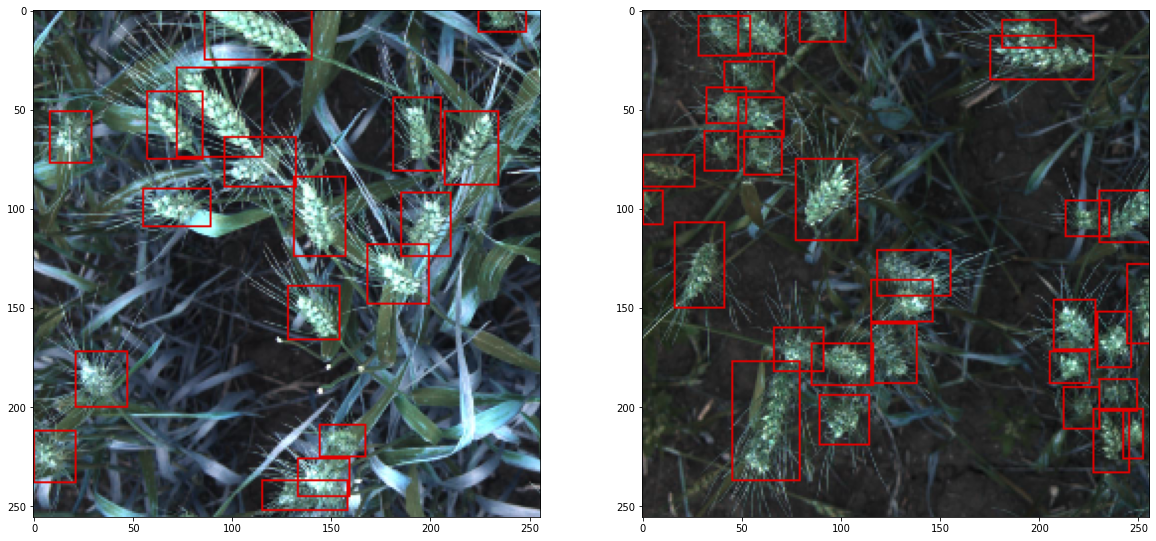

In [22]:
%%time
show_images((train_image_ids[100:102]),(train_labels))

In [23]:
def draw_grid_lines(image_id, labels, grid_line_distance=32, source='train'):
    global use_GPU
    
    image_path = './dataset/'+source+'/'+image_id+'.jpg'
    if use_GPU:
        image = cv2.UMat(draw_bboxes(image_id, labels))
    else:
        image = draw_bboxes(image_id, labels)
    image = cv2.resize(image, (256, 256))
    
    # Vertical Lines
    prev_x = 0
    prev_y = 0
    for dist in range(0, 256, grid_line_distance):
        image = cv2.line(image, (prev_x, prev_y+(dist-prev_y)), (prev_x+256, prev_y+(dist-prev_y)), (0, 0, 255), 1, 1)
        prev_x = prev_x
        prev_y = dist
    
    # Horizontal Lines
    prev_x = 0
    prev_y = 0
    for dist in range(0, 256, grid_line_distance):
        image = cv2.line(image, (prev_x+(dist-prev_x), prev_y), (prev_x+(dist-prev_x), prev_y+256), (0, 0, 255), 1, 1)
        prev_x = dist
        prev_y = prev_y
        
    if use_GPU:
        image = cv2.UMat.get(image)
        
    else:
        image = image

    return image
        

## Which grid size is optimal to select for Yolo-Similar model with an input image size of `256*256`?
Answer: below the plot

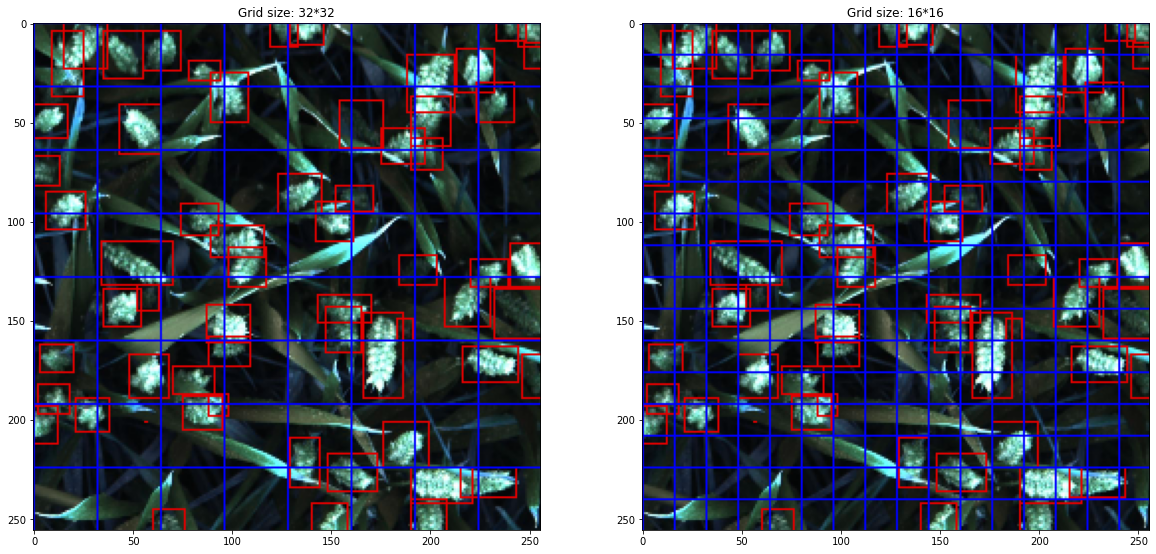

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10*2, 10*2))
image_id = train_image_ids[3000]
ax[0].set_title('Grid size: 32*32')
ax[0].imshow(draw_grid_lines(image_id, train_labels[image_id], grid_line_distance=32 )) # 32*32 grid
ax[1].set_title('Grid size: 16*16')
ax[1].imshow(draw_grid_lines(image_id, train_labels[image_id], grid_line_distance=16 )) # 16*16 grid
fig.show()

1. Here we can see that `32*32` grid is more effective than `16*16` 
2. `16*16` grid is too closely packed and the mid-points of the anchors are not clear, Therefore, selecting `32*32` grid size is optimal.

In [25]:
train_image_ids[100]

'4d60c73db'

In [26]:
val_image_ids[6]

'bce2fdc4d'

### Cleaning Very small boxes

In [27]:
tiny_boxes = []

for i, image_id in enumerate(train_image_ids):
    for label in train_labels[image_id]:
        if label[2]*label[3] <= 10 and label[2]*label[3] != 0:
            tiny_boxes.append(i)
print(str(len(tiny_boxes)) + ' tiny boxes found')

49 tiny boxes found


In [28]:
def clean_labels(train_image_ids, train_labels):
    good_labels = {}
    
    for i, image_id in enumerate(train_image_ids):
        good_labels[image_id] = []
        
        for j, label in enumerate(train_labels[image_id]):
            
            if label[2]*label[3] > 8000 and i not in [1079, 1371, 2020]:
                continue
                
            elif label[2]<5 or label[3]<5:
                continue
                
            else:
                good_labels[image_id].append(
                    train_labels[image_id][j]
                )
    return good_labels

In [29]:
train_labels = clean_labels(train_image_ids, train_labels)

# DataGenerator

In [30]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, image_ids, image_pixels, labels=None,  batch_size=1, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.image_ids))
        
        self.image_grid = self.form_image_grid()
        
    def form_image_grid(self):
        image_grid = np.zeros((32, 32, 4))
        
        cell = [0 ,0, 256/32, 256/32]
        
        for i in range(0, 32):
            for j in range(0, 32):
                image_grid[i, j] = cell
                
                cell[0] = cell[0] + cell[2]
                
            cell[0] = 0
            cell[1] = cell[1] + cell[3]
        
        return image_grid
    
    def __len__(self):
        return int(np.floor(len(self.image_ids)/self.batch_size))
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.image_ids))
        
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    

In [31]:
DataGenerator.train_augmentations = albu.Compose([
    albu.RandomSizedCrop(
        min_max_height=(200, 200),
        height=256,
        width=256,
        p=0.8
    ),
    
    # Flip Aguentation
    albu.OneOf([
        albu.Flip(),
        albu.RandomRotate90()], p=1),
    
    # Pixel Value Agumentaion
    albu.OneOf([
        albu.HueSaturationValue(),
        albu.RandomBrightnessContrast(),
    ], p=1),
    
    # Adding Noise to the Image Agumentation
    albu.OneOf([
        albu.GaussianBlur(),
        albu.GaussNoise(),
        albu.ISONoise(),
        albu.MultiplicativeNoise(),
    ], p=0.5),
    
    # Dropping out random regions in the image
    albu.Cutout(
        num_holes=8,
        max_h_size=16,
        max_w_size=16,
        fill_value=0,
        p=0.5
    ),
    
    albu.CLAHE(p=1),
    albu.ToGray(p=1),
    
], bbox_params={'format': 'coco', 'label_fields': ['labels']})

In [32]:
DataGenerator.val_agumentations = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1)
])

In [33]:
def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    
    batch_ids = [self.image_ids[i] for i in indexes]
    
    X, y = self.__data_generation(batch_ids)
    
    return X, y

In [34]:
def __data_generation(self, batch_ids):
    X, y = [], []
    
    # Data Generation
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]
        
        if self.augment:
            pixels, bboxes = self.agument_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.from_label_grid(bboxes)
            
        X.append(pixels)
        y.append(bboxes)
    return np.array(X), np.array(y)

In [35]:

def agument_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))
    aug_final = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)
    
    bboxes = self.form_label_grid(aug_final['bboxes'])
    return np.array(aug_final['image']), bboxes

def contrast_image(self, pixels):
    agu_final = self.val_agumentations(image=pixels)
    return np.array(agu_final['image'])/ 225

In [36]:
DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.agument_image = agument_image
DataGenerator.contrast_image = contrast_image

In [37]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((32,32,10))
    for i in range(0,32):
        for j in range(0,32):
            cell = self.image_grid[i, j]
            label_grid[i, j] = self.rect_intersect(cell, bboxes)
    return label_grid

def rect_intersect(self, cell, bboxes):
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x+cell_width
    cell_y_max = cell_y+cell_height
    
    anchor_one = np.array([0 ,0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])
    
    for bbox in bboxes:
        
        #print(bbox.shape)
        box_x, box_y, box_width, box_height = bbox
        box_x_center = box_x + (box_width / 2)
        box_y_center = box_y + (box_height / 2)
        
        if(box_x_center >= cell_x and box_x_center < cell_x_max and box_y_center >= cell_y and box_y_center < cell_y_max ):
            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height],
                    [cell_x, cell_x, cell_width, cell_height]
                )
            elif(anchor_two[0] == 0):
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_width],
                    [cell_x, cell_y, cell_width, cell_height]
                )
                
            else:
                break
        
    return np.concatenate((anchor_one, anchor_two), axis=None)

def yolo_shape(self, box, cell):
    
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell
    
    # Bottom left point(x, y) to center point(x, y) perspective of the whole Image
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)
    
    # Offset bbox (x, y) of Image perscpective to cell (x, y) perspective
    box_x = (box_x - cell_width) / cell_width
    box_y = (box_y - cell_height) / cell_height
    
    # bbox width, height in the perspective of cell
    box_width = box_width / 256
    box_height = box_height / 256
    
    return [1, box_x, box_y, box_width, box_height]
    

In [38]:
DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

# Yolo Model Creation!

In [39]:
def add_main_block(num_times_to_add_block: int, x, x_shortcut, filters: int, kernel_size: tuple, strides: tuple, block_number=None, padding: str ='same', alpha: str = 0.1):
    
    for _ in range(num_times_to_add_block):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=alpha)(x)
    
        x = Conv2D(filters*2, kernel_size, strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=alpha)(x)
    
        x = Add()([x_shortcut, x])
        x = LeakyReLU(alpha=alpha)(x)
        
        x_shortcut = x
        
    return x, x_shortcut

In [40]:
def add_res_block(x, x_shortcut=None, filters: int = None, kernel_size: tuple = None, strides: tuple = None, block_number=None, padding: str = 'same', alpha: float = 0.1):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=alpha)(x)

    x_shortcut = x
    
    return x, x_shortcut

In [52]:
x_input = Input(shape=(256, 256, 3))

x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)


#------------ Block 1 -------------#
#-- Res-block-1 --#
x, x_shortcut = add_res_block(x, filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)
#-- Main-Block-1 --#
x, x_shortcut = add_main_block(1, x, x_shortcut, filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)


#------------ Block 2 -------------#
#-- Res-block-2 --#
x, x_shortcut = add_res_block(x, x_shortcut=x_shortcut, filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)
#-- Main-Block 2 --#
x, x_shortcut = add_main_block(1, x, x_shortcut, filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)


#------------ Block 3 -------------#
#-- Res-block 3 --#
x, x_shortcut = add_res_block(x, x_shortcut, filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)
#-- Main-Block --#
x, x_shortcut = add_main_block(1, x, x_shortcut, filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)


#------------ Block 4 -------------#
#-- Res-Block 4 --#
x, x_shortcut = add_res_block(x, x_shortcut, filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)
#-- Main-Block 4 --#
x, x_shortcut = add_main_block(1, x, x_shortcut, filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)


#------------ Block 5 -------------#
#-- Res-Block 5 --#
# x, x_shortcut = add_res_block(x, x_shortcut, filters=1024, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)
# #-- Main-Block 5 --#
# x, x_shortcut = add_main_block(1, x, x_shortcut, filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)


#------------ Output Layers -------------#
x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

predictions= x = Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

model1 = Model(inputs=x_input, outputs=predictions)

In [56]:
x_input = tf.keras.Input(shape=(256,256,3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    
########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 5 ##########
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(4):
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=x_input, outputs=predictions)

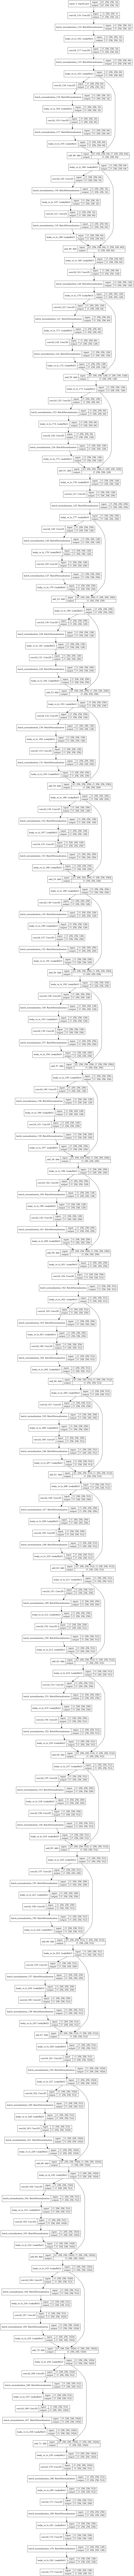

In [57]:
keras.utils.plot_model(model1, to_file="model1.png", show_layer_names=True, show_shapes=True, expand_nested=True)

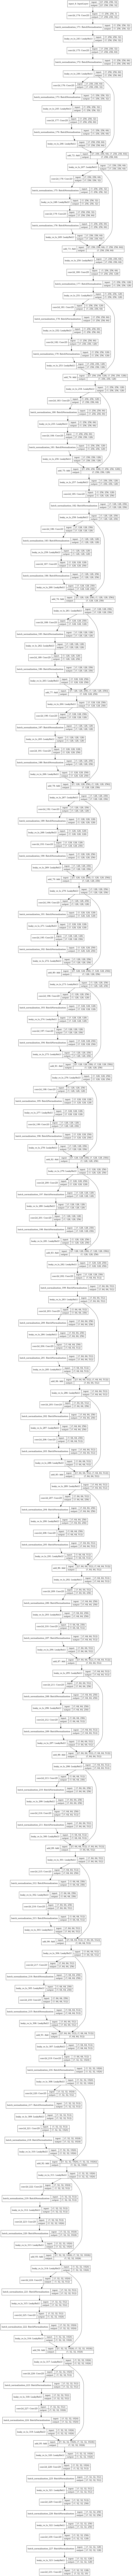

In [58]:
keras.utils.plot_model(model2, to_file="model2.png", show_layer_names=True, show_shapes=True, expand_nested=True)

In [53]:
model_sum = model1.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 256, 256, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 256, 256, 32) 128         conv2d_50[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_63 (LeakyReLU)      (None, 256, 256, 32) 0           batch_normalization_48[0][0]     
_______________________________________________________________________________________

In [54]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss*bboxes_mask
    wh_loss = wh_loss*bboxes_mask
    
    return prob_loss + xy_loss + wh_loss

def get_mask(y_true):
    
    anchor_one_mask = tf.where(
        y_true[:, :, :, 0] == 0,
        0.5,
        5
    )
    
    anchor_two_mask = tf.where(
        y_true[:, :, :, 0] == 0,
        0.5,
        5
    )
    
    bboxes_mask = tf.concat( 
        [anchor_one_mask, anchor_two_mask],
        axis=0          
    )
    
    return bboxes_mask

In [55]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model1.compile(
    optimizer=optimizer,
    loss = custom_loss
)

In [56]:
callback = [
     tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
     tf.keras.callbacks.ModelCheckpoint(filepath='yolo-similar-model-first.h5', monitor='loss', save_best_only=True, save_weights_only=True)
]

In [57]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels,
    batch_size=1,
    shuffle=True,
    augment=True
)

val_generator = DataGenerator(
    val_image_ids,
    val_pixels,
    val_labels,
    batch_size=10,
    shuffle=False,
    augment=False
)

image_grid = train_generator.image_grid

In [58]:
history = model1.fit(train_generator,
                    validation_data=val_generator,
                    epochs=80, 
                    callbacks=callback)

Epoch 1/80


InvalidArgumentError:  Incompatible shapes: [2,2,256,256] vs. [2,2,32,32]
	 [[node custom_loss/SquaredDifference (defined at <ipython-input-46-51c397d1ded9>:11) ]] [Op:__inference_train_function_14321]

Function call stack:
train_function


In [151]:
from numba import cuda

In [153]:
device = cuda.get_current_device()

In [157]:
device.reset()

In [68]:
x_input = tf.keras.Input(shape=(256,256,3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    
########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 5 ##########
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

model = tf.keras.Model(inputs=x_input, outputs=predictions)

In [69]:
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_307 (Conv2D)             (None, 256, 256, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_300 (BatchN (None, 256, 256, 32) 128         conv2d_307[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_419 (LeakyReLU)     (None, 256, 256, 32) 0           batch_normalization_300[0][0]    
______________________________________________________________________________________